# Exploratory Data Analysis (EDA) on Solar Panel Efficiency

## 1. Introduction

The objective of this exploratory data analysis (EDA) is to understand the factors that influence the efficiency of solar panels. Solar panel efficiency is crucial for maximizing power generation and ensuring cost-effectiveness and reliability in solar power systems. By analyzing historical weather and air quality data, we aim to identify patterns and relationships that can help predict solar panel efficiency.

### Dataset Description

The datasets used in this analysis include:

1. **Weather Data:** This dataset contains daily weather records, including temperature, rainfall, wind speed, sunshine duration, cloud cover, and relative humidity, among other variables.
2. **Air Quality Data:** This dataset includes daily air quality measurements, such as particulate matter (PM2.5) and Pollutant Standards Index (PSI) values for different regions.

### Analysis Goals

The primary goals of this EDA are:

1. **Understand Data Structure:** Inspect and clean the datasets to ensure data quality.
2. **Identify Key Variables:** Determine which weather and air quality variables are most relevant to solar panel efficiency.
3. **Explore Relationships:** Analyze the relationships between different variables and solar panel efficiency.
4. **Feature Engineering:** Create new features that could improve the predictive power of machine learning models.
5. **Generate Insights:** Draw insights from the data that can inform future model development and operational strategies.

In the following sections, we will outline the steps taken in this analysis, provide explanations for each step, and present visualizations to support our findings. Let's begin with loading and inspecting the data.


## 2. Data Loading and Initial Inspection

In this section, we will load the weather and air quality datasets from the provided SQLite databases. We will inspect the first few rows of each dataset to understand their structure and content. Additionally, we will check for any missing values or anomalies that may need to be addressed during data preprocessing.

### Steps:

1. **Load Data:** Use the `sqlite3` library to connect to the databases and load the data into pandas DataFrames.
2. **Inspect Data:** Display the first few rows of each dataset to understand their structure.
3. **Check for Missing Values:** Identify any missing values in the datasets.
4. **Summary Statistics:** Generate summary statistics to get an overview of the data distribution.

### Data Loading Code

The following function, `load_data` from data_loader.py, is used to connect to the SQLite databases and load the data into pandas DataFrames.

It takes the path to the data directory as an argument and uses sqlite3.connect to establish a connection to the weather and air quality databases.

```python
import sqlite3

def load_data(db_path):
    conn_weather = sqlite3.connect(f'{db_path}/weather.db')
    weather_df = pd.read_sql_query("SELECT * FROM weather", conn_weather)
    conn_weather.close()

    conn_air_quality = sqlite3.connect(f'{db_path}/air_quality.db')
    air_quality_df = pd.read_sql_query("SELECT * FROM air_quality", conn_air_quality)
    conn_air_quality.close()

    return weather_df, air_quality_df

In [1]:
# Import required libraries and scripts
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import load_data, convert_date_columns
from src.data_preprocessing import preprocess_data
from src.feature_engineering import feature_engineer, encode_target
from src.train_model import train_and_evaluate, hyperparameter_tuning_and_evaluate_grid, train_with_best_params, evaluate_model
from imblearn.over_sampling import SMOTE

# Set the path to your data directory
DB_PATH = 'data'

# Load the data
weather_df, air_quality_df = load_data(DB_PATH)


In [2]:
# Convert Date to Datetime
weather_df, air_quality_df = convert_date_columns(weather_df, air_quality_df)
# Display first few rows of the dataset for weather_df and air_quality_df
display(weather_df.head())
display(air_quality_df.head())

# Show data types of each column
display(weather_df.dtypes)
display(air_quality_df.dtypes)


,data_ref,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,2014-04-01,-,2,2,2,28.4,32.4,7.5,25.9,8.07,18.0,-59.3,100.0,1006,VH,W,High
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,2014-04-02,0,0,0,--,28.8,32.6,--,33.1,7.57,23.0,59.2,100.0,1005,Very High,S,Medium
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,2014-04-03,0,0,0,0,29.3,--,--,43.2,6.72,16.0,59.7,98.5,1005,Low,E,Medium
3,7a404c50-710f-451a-9a42-a66bb783a3d0,2014-04-04,0,0,0,0,28.6,32.4,7.4,33.1,7.55,20.0,59.1,100.0,1011,Very High,W,Medium
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,2014-04-05,23.4,15.2,17.2,17.4,26.4,28,5.4,28.1,5.27,74.0,58.9,100.0,1012,Very High,east,Low


,data_ref,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,2014-04-01,20,16,18,23,19,58,56,57,66,59
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,2014-04-02,18,14,-,22,16,57,53,54,61,56
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,2014-04-03,12,12,10,14,10,55,53,52,59,54
3,7a404c50-710f-451a-9a42-a66bb783a3d0,2014-04-04,--,-,24,19,25,58,57,55,-,56
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,2014-04-05,18,19,21,13,17,64,64,66,-,66


data_ref                                 object
date                             datetime64[ns]
Daily Rainfall Total (mm)                object
Highest 30 Min Rainfall (mm)             object
Highest 60 Min Rainfall (mm)             object
Highest 120 Min Rainfall (mm)            object
Min Temperature (deg C)                  object
Maximum Temperature (deg C)              object
Min Wind Speed (km/h)                    object
Max Wind Speed (km/h)                    object
Sunshine Duration (hrs)                 float64
Cloud Cover (%)                         float64
Wet Bulb Temperature (deg F)            float64
Relative Humidity (%)                   float64
Air Pressure (hPa)                        int64
Dew Point Category                       object
Wind Direction                           object
Daily Solar Panel Efficiency             object
dtype: object

data_ref                object
date            datetime64[ns]
pm25_north              object
pm25_south              object
pm25_east               object
pm25_west               object
pm25_central            object
psi_north               object
psi_south               object
psi_east                object
psi_west                object
psi_central             object
dtype: object

In [3]:
# Count missing values in each column in weather_df
missing_values = weather_df.isnull().sum()
display(missing_values)


data_ref                          0
date                              0
Daily Rainfall Total (mm)         0
Highest 30 Min Rainfall (mm)      0
Highest 60 Min Rainfall (mm)      0
Highest 120 Min Rainfall (mm)     0
Min Temperature (deg C)           0
Maximum Temperature (deg C)       0
Min Wind Speed (km/h)             0
Max Wind Speed (km/h)            15
Sunshine Duration (hrs)          16
Cloud Cover (%)                  16
Wet Bulb Temperature (deg F)      0
Relative Humidity (%)             0
Air Pressure (hPa)                0
Dew Point Category                0
Wind Direction                    0
Daily Solar Panel Efficiency      0
dtype: int64

In [4]:
# Count missing values in each column in air_quality_df
missing_values = air_quality_df.isnull().sum()
display(missing_values)

data_ref         0
date             0
pm25_north      39
pm25_south      39
pm25_east       39
pm25_west       39
pm25_central    39
psi_north       39
psi_south       39
psi_east        39
psi_west        39
psi_central     39
dtype: int64

In [5]:
# Identify columns with infinite values
infinite_values_weather = weather_df.isin([np.inf, -np.inf]).sum()
display(infinite_values_weather)
infinite_values_air = air_quality_df.isin([np.inf, -np.inf]).sum()
display(infinite_values_air)

data_ref                         0
date                             0
Daily Rainfall Total (mm)        0
Highest 30 Min Rainfall (mm)     0
Highest 60 Min Rainfall (mm)     0
Highest 120 Min Rainfall (mm)    0
Min Temperature (deg C)          0
Maximum Temperature (deg C)      0
Min Wind Speed (km/h)            0
Max Wind Speed (km/h)            0
Sunshine Duration (hrs)          0
Cloud Cover (%)                  0
Wet Bulb Temperature (deg F)     0
Relative Humidity (%)            0
Air Pressure (hPa)               0
Dew Point Category               0
Wind Direction                   0
Daily Solar Panel Efficiency     0
dtype: int64

data_ref        0
date            0
pm25_north      0
pm25_south      0
pm25_east       0
pm25_west       0
pm25_central    0
psi_north       0
psi_south       0
psi_east        0
psi_west        0
psi_central     0
dtype: int64

In [6]:
# Identify columns with negative values
negative_values = weather_df.select_dtypes(include=[np.number]).lt(0).sum()
display(negative_values)


Sunshine Duration (hrs)           0
Cloud Cover (%)                   0
Wet Bulb Temperature (deg F)    178
Relative Humidity (%)             0
Air Pressure (hPa)                0
dtype: int64

## Initial exploration insights

### Initial Observations:
- Weather Data:

The dataset contains various weather-related variables such as temperature, rainfall, wind speed, sunshine duration, and cloud cover.

- Air Quality Data:

The dataset includes measurements of particulate matter (PM2.5) and Pollutant Standards Index (PSI) for different regions.


### Based on the initial exploration, we identified several issues in the weather & air quality dataset):
- Missing values in multiple columns.
- Negative values in columns where they are not logically possible (e.g. wind speed).


## 3. Detailed Exploration
In this step, we will perform a more detailed exploration of the datasets. This involves visualizing the data and calculating correlation matrices.

,date,Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa)
count,3517,3501.000000,3501.000000,3517.000000,3517.000000,3517.000000
mean,2018-08-18 05:47:36.866647552,7.018320,28.682376,52.946062,97.366761,1008.668467
min,2014-04-01 00:00:00,0.000000,2.000000,-60.700000,68.600000,998.000000
25%,2016-06-02 00:00:00,6.710000,17.000000,58.400000,96.700000,1006.000000
50%,2018-08-18 00:00:00,7.400000,22.000000,58.900000,100.000000,1009.000000
75%,2020-10-27 00:00:00,7.840000,30.000000,59.400000,100.000000,1011.000000
max,2022-12-31 00:00:00,9.150000,100.000000,61.800000,100.000000,1020.000000
std,NaN,1.389904,20.788299,25.842174,5.043705,3.513724


,date
count,3875
mean,2018-08-09 17:17:32.593548288
min,2014-04-01 00:00:00
25%,2016-05-28 12:00:00
50%,2018-08-02 00:00:00
75%,2020-10-22 12:00:00
max,2022-12-31 00:00:00


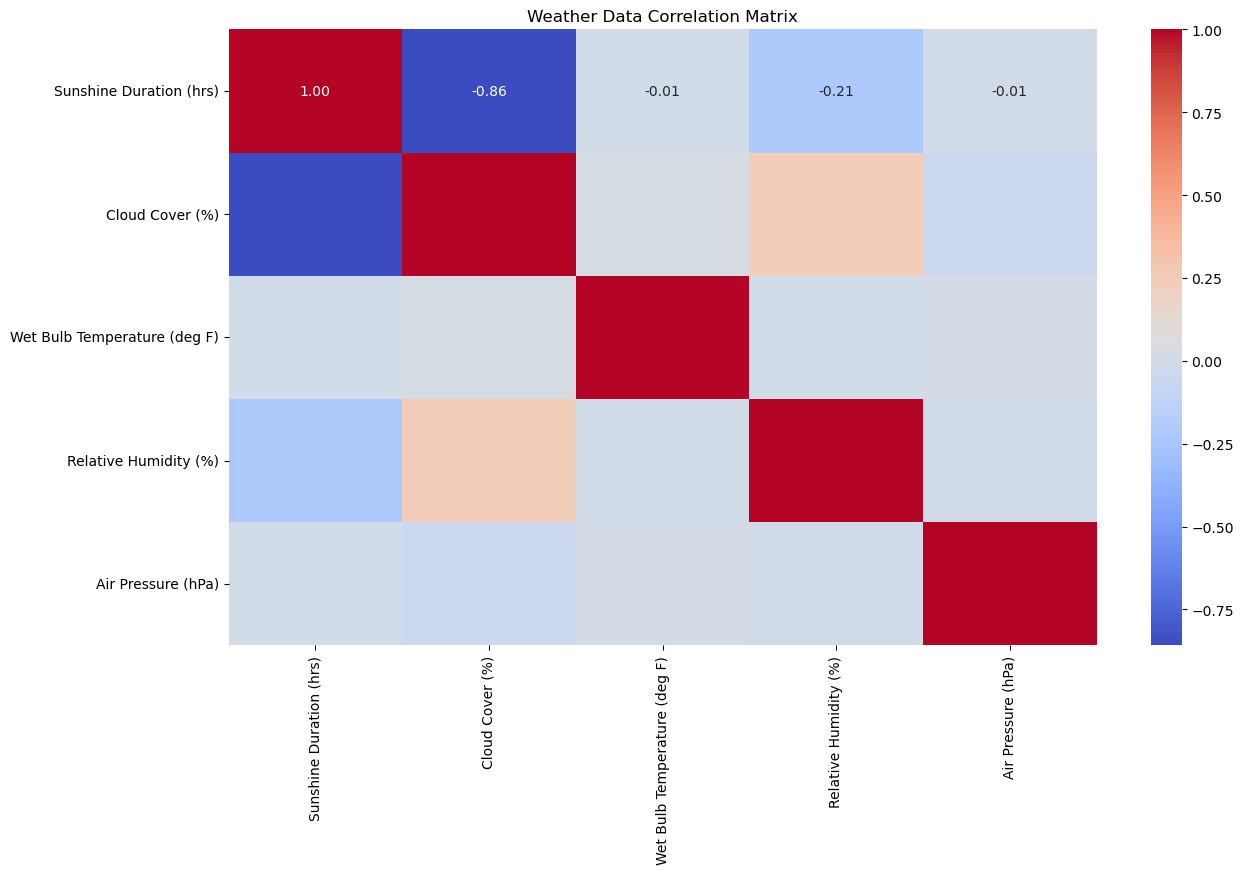

No numeric columns found in air_quality_df.


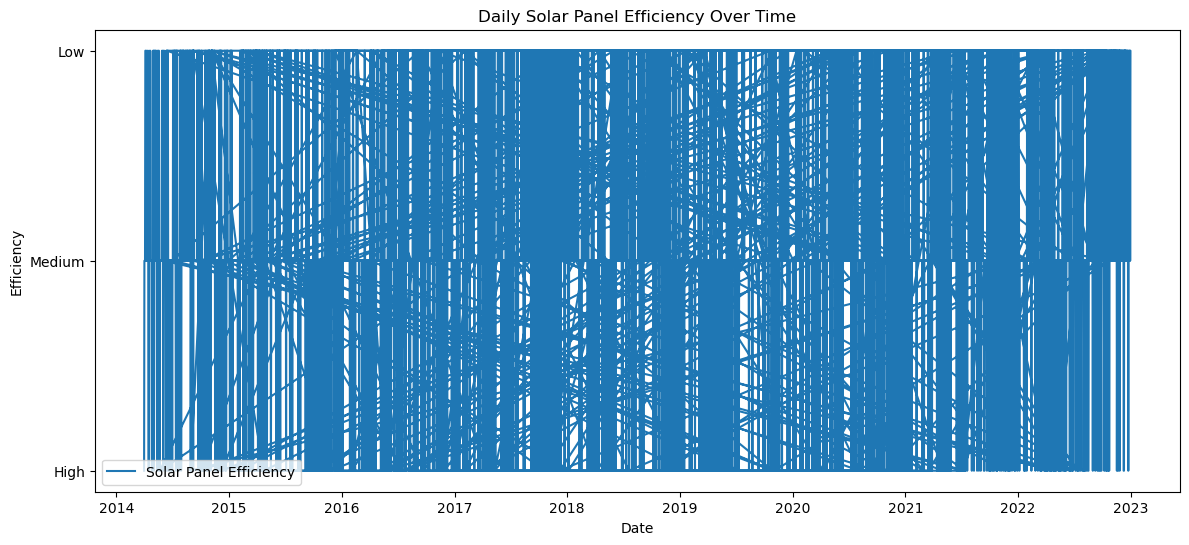

In [7]:
# Exploratory Data Analysis (EDA)

# Summary statistics
display(weather_df.describe())
display(air_quality_df.describe())

# Extract numeric columns for correlation matrix
numeric_weather_df = weather_df.select_dtypes(include=[np.number])
numeric_air_quality_df = air_quality_df.select_dtypes(include=[np.number])

# Check if numeric dataframes are empty
if numeric_weather_df.empty:
    print("No numeric columns found in weather_df.")
else:
    # Visualize correlation matrix for weather data
    plt.figure(figsize=(14, 8))
    sns.heatmap(numeric_weather_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Weather Data Correlation Matrix')
    plt.show()

if numeric_air_quality_df.empty:
    print("No numeric columns found in air_quality_df.")
else:
    # Visualize correlation matrix for air quality data
    plt.figure(figsize=(10, 6))
    sns.heatmap(numeric_air_quality_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Air Quality Data Correlation Matrix')
    plt.show()

# Time series plots
plt.figure(figsize=(14, 6))
plt.plot(weather_df['date'], weather_df['Daily Solar Panel Efficiency'], label='Solar Panel Efficiency')
plt.xlabel('Date')
plt.ylabel('Efficiency')
plt.title('Daily Solar Panel Efficiency Over Time')
plt.legend()
plt.show()


### Insight from Summary Statistics:

- The weather data spans from April 1, 2014, to December 31, 2022, and contains measurements such as sunshine duration, cloud cover, wet bulb temperature, relative humidity, and air pressure.
- The air quality data also spans the same period, but currently, no numeric columns were found in the dataset after conversion attempts, indicating a need for further preprocessing.
- There are some extreme values, such as a minimum wet bulb temperature of -60.7°F, which may require special attention during preprocessing.

#### Correlation Matrices

**Insights:**

- Sunshine Duration (hrs) has a strong negative correlation with Cloud Cover (%), indicating that more cloud cover typically results in less sunshine duration.
- Relative Humidity (%) shows a moderate negative correlation with Air Pressure (hPa).
- No significant correlations with Wet Bulb Temperature (deg F) wh**Air Quality Data:**ment:image.png)

#### Air Quality Data
**Insights:**

- No numeric columns were found in the air quality data after initial processing. This indicates a need to revisit and ensure that columns intended to be numeric are properly converted from object types during pTime Series Plot of Solar Panel Efficiency(attachment:image.png)

#### Time Series Plot of Solar Panel Efficiency

**Insights:**

- The plot is cluttered due to a large number of data points. It shows the solar panel efficiency over time, categorized as Low, Medium, or High.
- Further refinement and preprocessing are needed to make this visualization more meaningful.

### Preprocessing Advice

1. **Convert Columns to Numeric**: Ensure that columns containing numeric data are correctly converted from object types to numeric types. This involves handling special characters and missing values appropriately.
2. **Handle Missing Values**: Use appropriate strategies such as forward filling or replacing missing values with mean or median values.
3. **Address Extreme Values**: Identify and handle extreme values that may affect model performance, such as the unusually low wet bulb temperature.
4. **Standardize Data**: Standardize numeric data to ensure consistent scale across features.
5. **Recheck Air Quality Data**: Ensure that numeric columns in the air quality data are correctly identified and converted during preprocessing.

With these insights and preprocessing steps in mind, we can proceed to refine the preprocessing function and reattempt the EDA with clean and appropriately formatted data.


### Preprocessing Strategy

In this step, we preprocess the weather and air quality datasets to ensure they are clean and ready for analysis and modeling. The preprocessing steps include handling missing values, converting data types, addressing extreme values, and standardizing the data.

#### Handling Missing Values

1. **Forward Fill**: Missing values are initially handled using forward fill (`ffill`). This method propagates the last valid observation forward. This is particularly useful for time series data, where the assumption is that the last recorded value is a reasonable estimate for subsequent missing values.
   
   ```python
   weather_df.ffill(inplace=True)
   air_quality_df.ffill(inplace=True)
   ```
   
2. **Replacing Special Characters** :  Special characters like --, -, and empty strings are replaced with NaN to facilitate their conversion to numeric types.
    ```
    special_chars = ['--', '-', '']
    weather_df.replace(special_chars, pd.NA, inplace=True)
    air_quality_df.replace(special_chars, pd.NA, inplace=True)



3. **Convert to Numeric**: Columns intended to be numeric are converted from object types to numeric types. Any conversion errors result in NaN values, which are subsequently handled.
    ```
    weather_df[weather_numeric_cols] = weather_df[weather_numeric_cols].apply(pd.to_numeric, errors='coerce')
    air_quality_df[air_quality_numeric_cols] = air_quality_df[air_quality_numeric_cols].apply(pd.to_numeric, errors='coerce')



4. **Fill Remaining NaNs with Column Means**: Remaining NaN values are filled with the mean of the respective columns. This helps maintain the distribution of the data without introducing significant bias.
   ```
    weather_df.fillna(weather_df.mean(), inplace=True)
    air_quality_df.fillna(air_quality_df.mean(), inplace=True)


 
5. **Addressing Extreme Values**: Replace Infinite Values: Any infinite values are replaced with NaN and subsequently handled as missing values.
    ```
    weather_df.replace([np.inf, -np.inf], pd.NA, inplace=True)
    air_quality_df.replace([np.inf, -np.inf], pd.NA, inplace=True)
    weather_df.fillna(0, inplace=True)
    air_quality_df.fillna(0, inplace=Tr



6. **Standardization** : Standardize Numeric Data: Numeric columns are standardized using the StandardScaler from scikit-learn. Standardization ensures that each feature contributes equally to the analysis by having a mean of 0 and a standard deviation of 1.
    ```
    scaler = StandardScaler()
    weather_scaled_df = pd.DataFrame(scaler.fit_transform(weather_df[weather_numeric_cols]), columns=weather_numeric_cols)
    air_quality_scaled_df = pd.DataFrame(scaler.fit_transform(air_quality_df[air_quality_numeric_cols]), columns=air_quality_numeric_col



7. **Add Non-Numeric Columns Back**: Non-numeric columns such as date and Daily Solar Panel Efficiency are added back to the scaled
    ```
    DataFrame.sweather_scaled_df['date'] = weather_df['date'].values
    weather_scaled_df['Daily Solar Panel Efficiency'] = weather_df['Daily Solar Panel Efficiency'].values
    air_quality_scaled_df['date'] = air_quality_df['date'].values
    

In [8]:
# Preprocess data using the functions from data_preprocessing.py
weather_df, air_quality_df = preprocess_data(weather_df, air_quality_df)


In [9]:
# Display the first few rows of the preprocessed dataframes to check the data
print("Preprocessed Weather Data:")
print(weather_df.head())

print("Preprocessed Air Quality Data:")
print(air_quality_df.head())

Preprocessed Weather Data:
   Air Pressure (hPa)  Cloud Cover (%)  Daily Rainfall Total (mm)  \
0           -0.759549        -0.513415               1.492886e-16   
1           -1.044188        -0.272503              -4.412020e-01   
2           -1.044188        -0.609780              -4.412020e-01   
3            0.663645        -0.417050              -4.412020e-01   
4            0.948283         2.184794               1.525381e+00   

   Highest 120 Min Rainfall (mm)  Highest 30 Min Rainfall (mm)  \
0                      -0.258326                     -0.181924   
1                       0.000000                     -0.498942   
2                      -0.479140                     -0.498942   
3                      -0.479140                     -0.498942   
4                       1.441946                      1.910396   

   Highest 60 Min Rainfall (mm)  Max Wind Speed (km/h)  \
0                     -0.224394              -0.276644   
1                     -0.479784              

#### Result of Preprocessing

The output of the preprocessing step is a cleaned and standardized dataset where all numeric columns have been scaled. This ensures that the data is in a suitable format for machine learning models, which often require standardized inputs.

### Further Visualizations
Further visualizations can help us understand the relationships between features in the dataset and identify strong correlations, which can guide the feature engineering step.

#### Visualization techniques employed:
1. Heatmaps for Correlation: To visualize the correlations between features.
2. Pairplots: To see pairwise relationships in the dataset.
3. Histograms and Boxplots: To visualize the distributions and potential outliers in each feature.

In [10]:
# Combine weather and air quality data for visualizations
combined_df = pd.merge(weather_df, air_quality_df, on='date', how='inner')

# Encode the target variable using the encode_target function for visualization 
combined_df = encode_target(combined_df)
weather_df = encode_target(weather_df)

In [11]:
# Drop non-numeric columns for correlation heatmap
weather_df_numeric = weather_df.select_dtypes(include=[np.number])
air_quality_df_numeric = air_quality_df.select_dtypes(include=[np.number])
combined_df_numeric = combined_df.select_dtypes(include=[np.number])

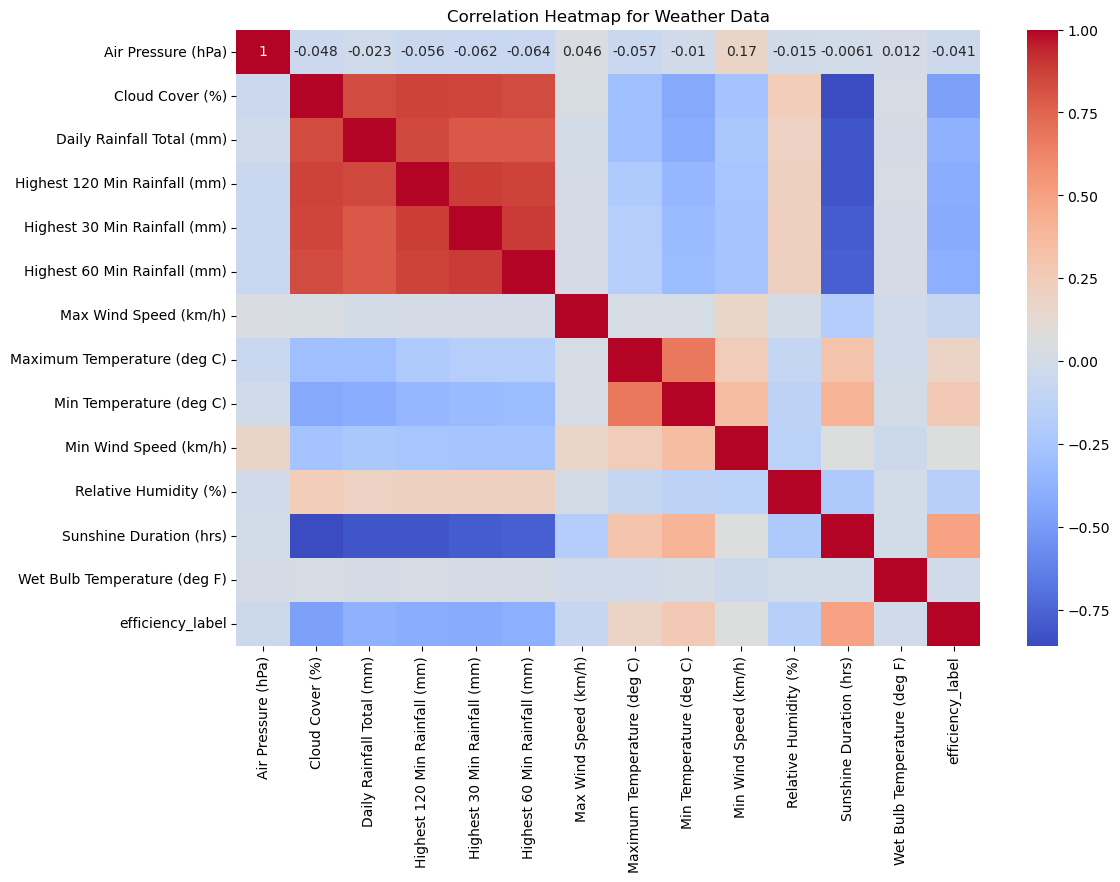

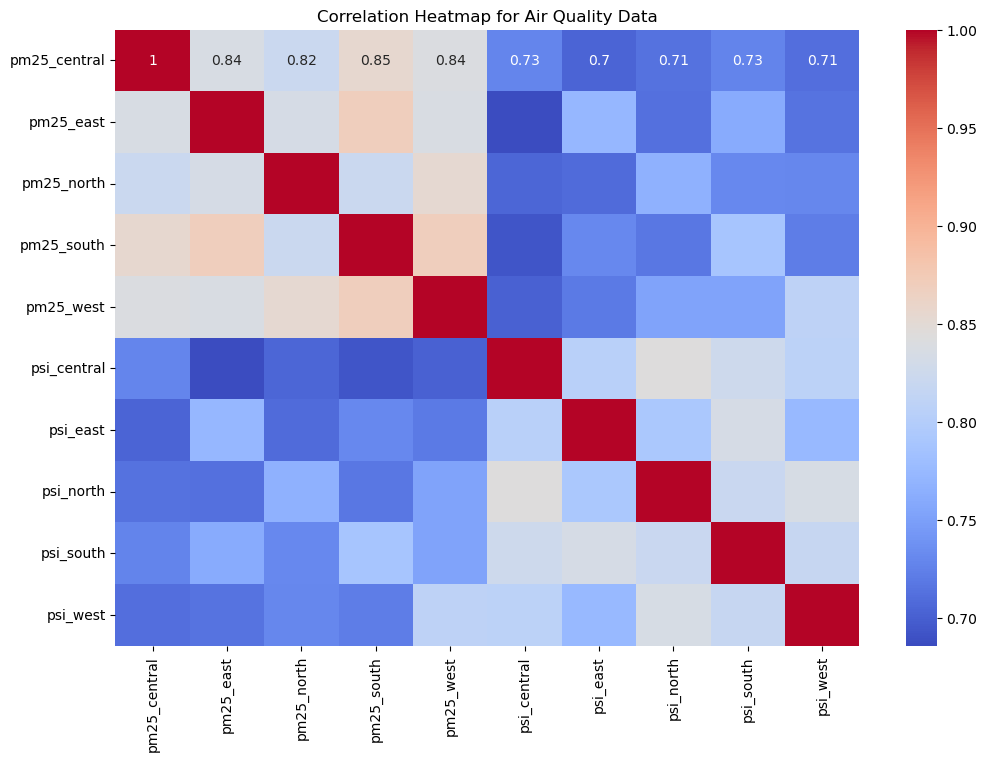

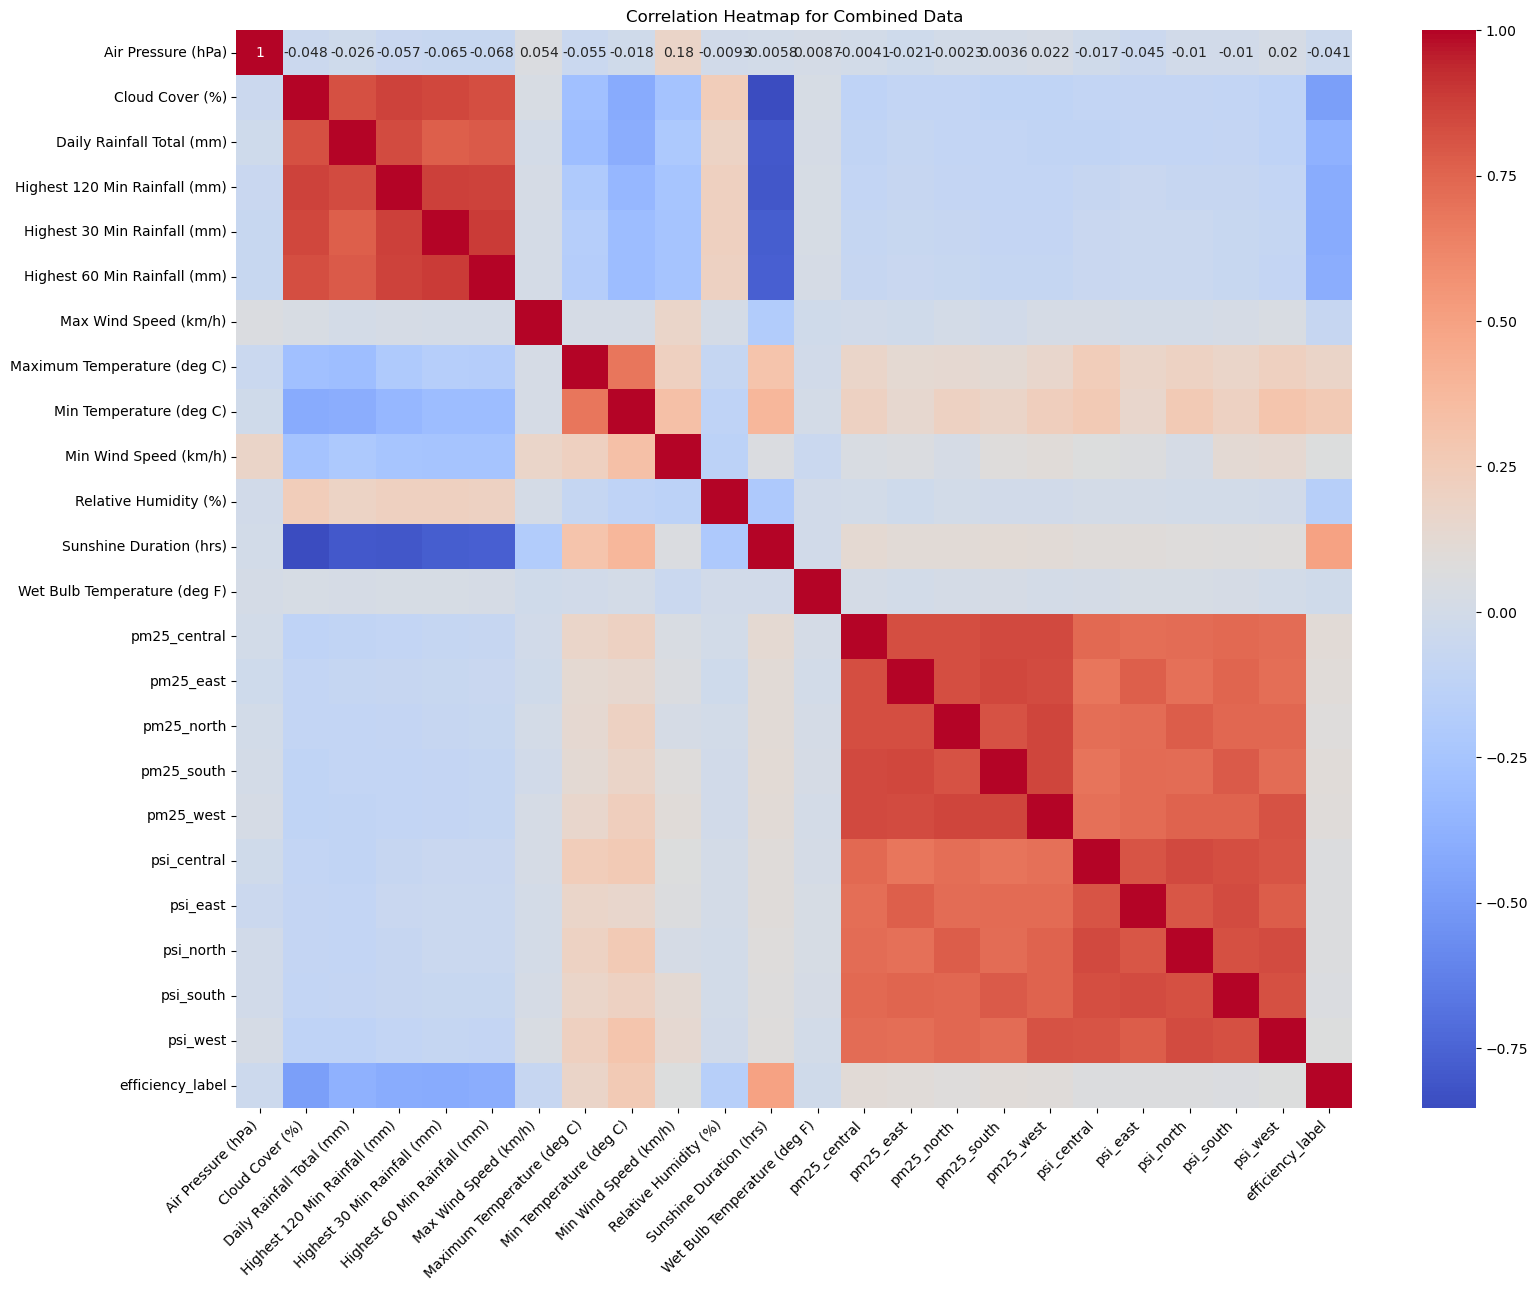

In [12]:
# Heatmap for weather data
plt.figure(figsize=(12, 8))
sns.heatmap(weather_df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Weather Data')
plt.show()

# Heatmap for air quality data
plt.figure(figsize=(12, 8))
sns.heatmap(air_quality_df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Air Quality Data')
plt.show()

# Heatmap for combined data with larger figure size and adjusted annotation size
plt.figure(figsize=(18, 14))
sns.heatmap(combined_df_numeric.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 10})
plt.title('Correlation Heatmap for Combined Data')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

### Interpretation of Correlation Heatmaps

#### Weather Data Correlation Heatmap: *note that correlation numbers are in a different scale due to our previous preprocessing step performed on data

- Temperature Relationships: Maximum temperature has a moderate negative correlation with minimum temperature, indicating that as the maximum temperature increases, the minimum temperature tends to decrease slightly.
- Rainfall Relationships: Different rainfall measurements (daily, 30 min, 60 min, 120 min) are highly correlated with each other, as expected.
- Sunshine Duration: Sunshine duration is negatively correlated with several other weather parameters, indicating that higher sunshine duration is associated with lower values of other weather metrics like rainfall and humidity.

#### Air Quality Data Correlation Heatmap:

- PM2.5 Levels: There are strong correlations between PM2.5 levels at different locations, indicating that PM2.5 levels tend to increase or decrease together across regions.
- PSI Levels: PSI levels also show strong correlations across different locations, indicating similar trends in air quality index measurements across regions.

#### Combined Data Correlation Heatmap:

- Temperature and Humidity: Similar correlations as seen in the individual heatmaps, with temperature and humidity showing expected relationships.
- Air Quality and Weather: There are moderate correlations between weather parameters and air quality indices, which could be further explored for feature engineering.
- Efficiency Label: The efficiency label has some correlations with both weather and air quality parameters, which could be leveraged for predicting solar panel efficiency.

C:\ProgramData\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

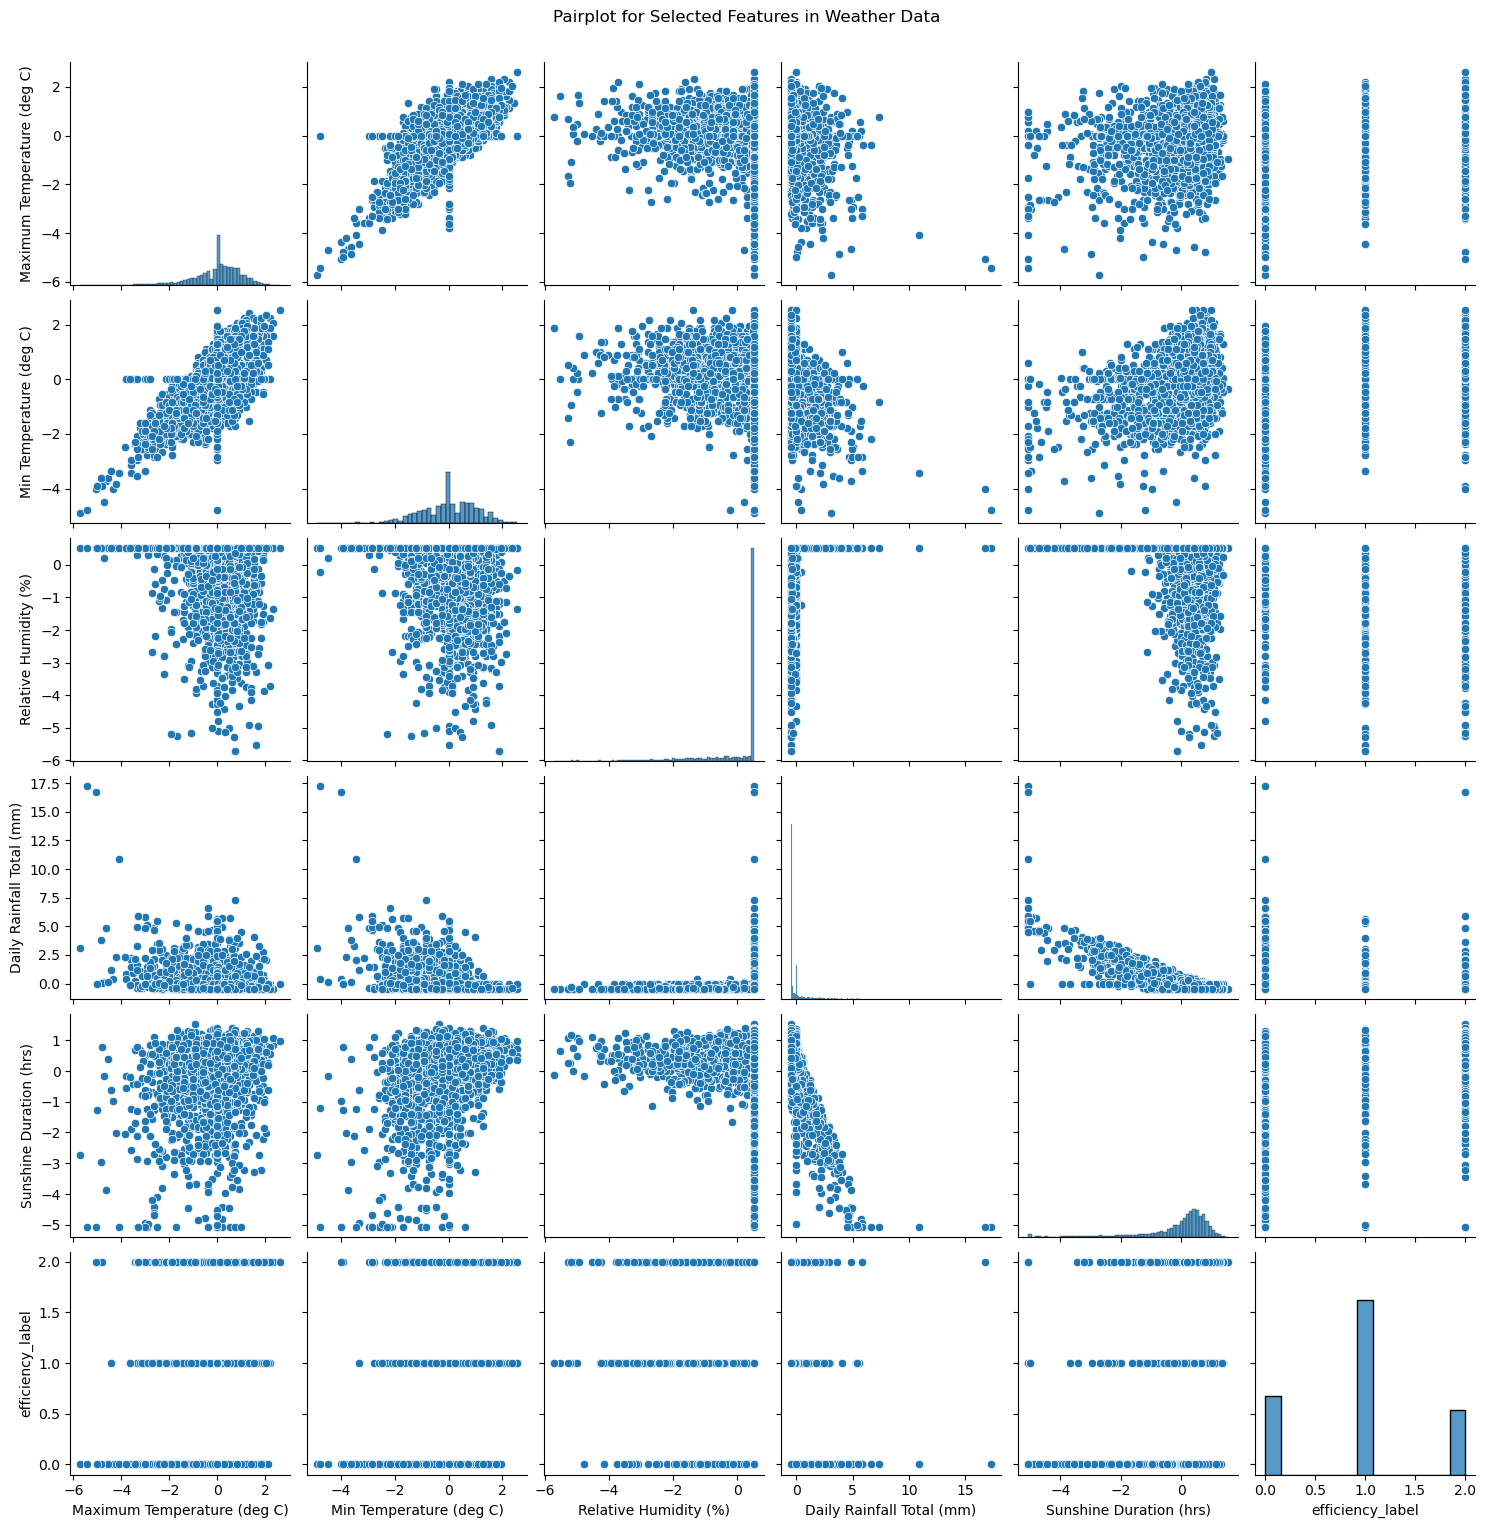

In [13]:
# Select a subset of relevant features for pairplot
selected_features = [
    'Maximum Temperature (deg C)', 'Min Temperature (deg C)',
    'Relative Humidity (%)', 'Daily Rainfall Total (mm)',
    'Sunshine Duration (hrs)', 'efficiency_label'
]

# Pairplot for selected features in the weather data
sns.pairplot(weather_df[selected_features])
plt.suptitle('Pairplot for Selected Features in Weather Data', y=1.02)
plt.show()

### Insights from the Pairplot:

#### Temperature Relationships:

- Maximum Temperature vs. Minimum Temperature: There is a strong positive linear relationship between maximum and minimum temperature, indicating that as the maximum temperature increases, the minimum temperature tends to increase as well.
  
- Temperature vs. Relative Humidity: Both maximum and minimum temperatures show a negative relationship with relative humidity, suggesting that higher temperatures are associated with lower humidity levels.
Rainfall and Sunshine:

- Daily Rainfall Total vs. Sunshine Duration: There is a noticeable negative relationship between daily rainfall total and sunshine duration. This indicates that on days with more rainfall, there tends to be less sunshine, which is expected.
Efficiency Label:

The distribution of efficiency labels shows that the dataset contains imbalanced classes, with more instances of Medium efficiency compared to Low and High efficiency.

C:\ProgramData\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping w

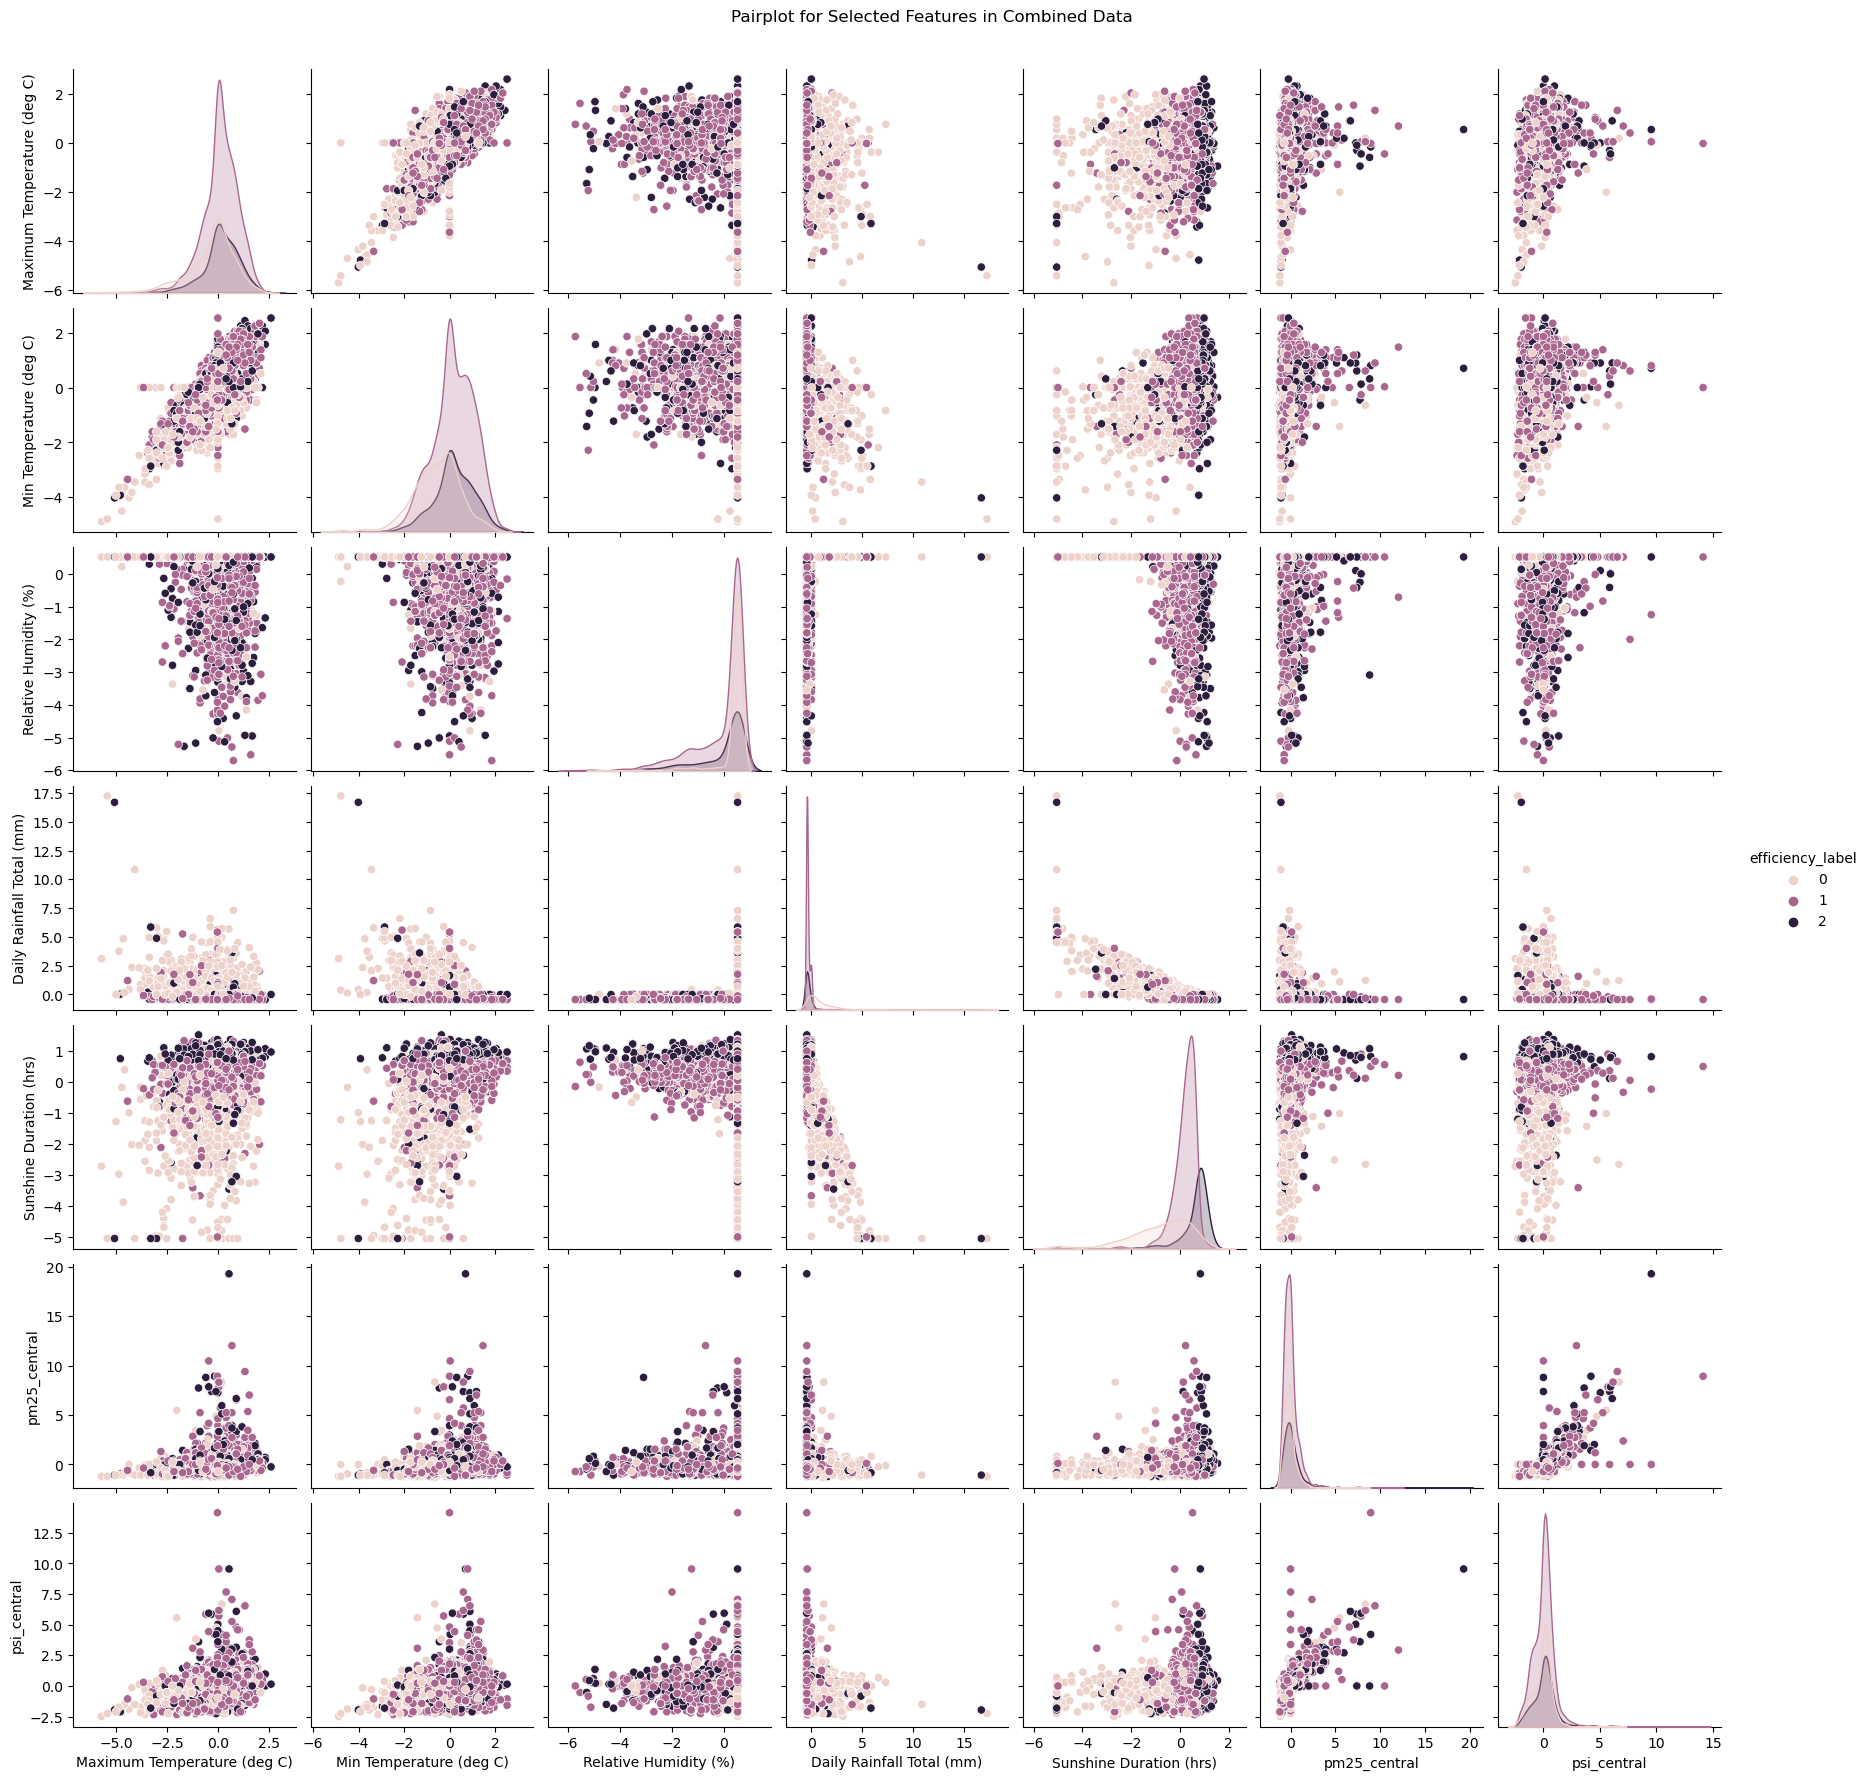

In [14]:
# Pairplot for selected features in the combined data
combined_selected_features = selected_features + [
    'pm25_central', 'psi_central'
]
sns.pairplot(combined_df[combined_selected_features], diag_kind='kde', hue='efficiency_label')
plt.suptitle('Pairplot for Selected Features in Combined Data', y=1.02)
plt.show()

### Insights from the Pairplot for Selected Features in Combined data(Weather+Air quality):
#### Temperature Relationships:

- Maximum Temperature vs. Minimum Temperature: There is a strong positive correlation between maximum and minimum temperatures, indicating that they tend to rise and fall together.

- Temperature vs. Efficiency: Higher maximum and minimum temperatures show a tendency towards higher efficiency levels, though the relationship is not strictly linear.
Humidity and Rainfall:

- Relative Humidity vs. Daily Rainfall Total: There is a slight positive correlation, suggesting that higher humidity is associated with more rainfall.
  
- Relative Humidity vs. Efficiency: Higher humidity appears to be associated with lower efficiency levels.
Sunshine Duration:

- Sunshine Duration vs. Efficiency: Longer sunshine duration is generally associated with higher efficiency levels, indicating the importance of sunlight in solar panel performance.
  
- Sunshine Duration vs. Temperature: Sunshine duration shows a positive relationship with temperature, particularly with maximum temperature.
Air Quality Metrics:

- PM2.5 and PSI Measurements: The different PM2.5 and PSI measurements (e.g., pm25_central, psi_central) are strongly correlated with each other, reflecting the consistent monitoring across different regions.
  
- Air Quality vs. Efficiency: There is no strong direct correlation observed between air quality metrics and efficiency, but it's worth exploring interaction effects with other weather variables.
  
#### Interactions to Explore:

- Temperature-Humidity Interaction: Given the interactions between temperature and humidity, creating interaction terms (e.g., product of temperature and humidity) might capture complex relationships affecting efficiency.
- Rainfall-Sunshine Interaction: Combining rainfall and sunshine duration into a single feature could capture the trade-off between rainy and sunny periods impacting efficiency.

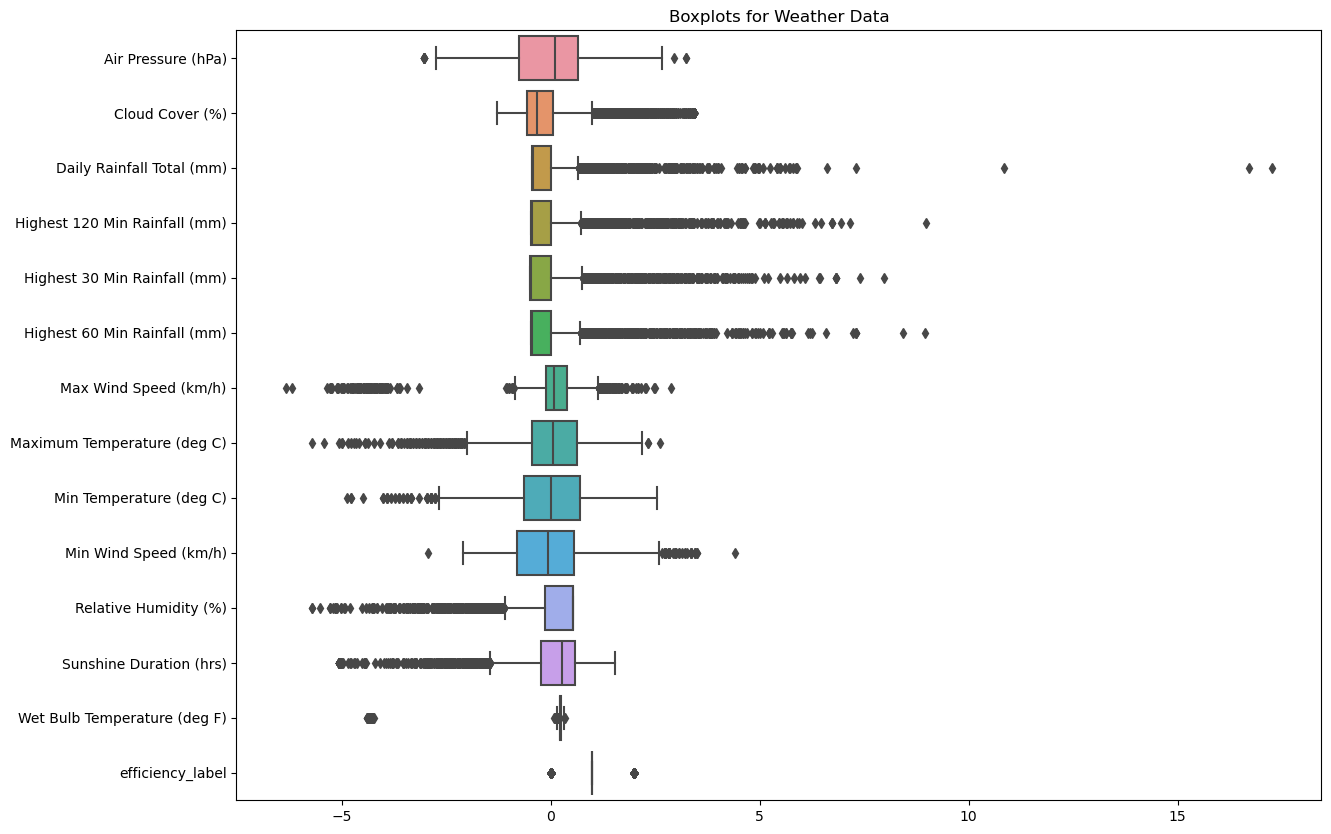

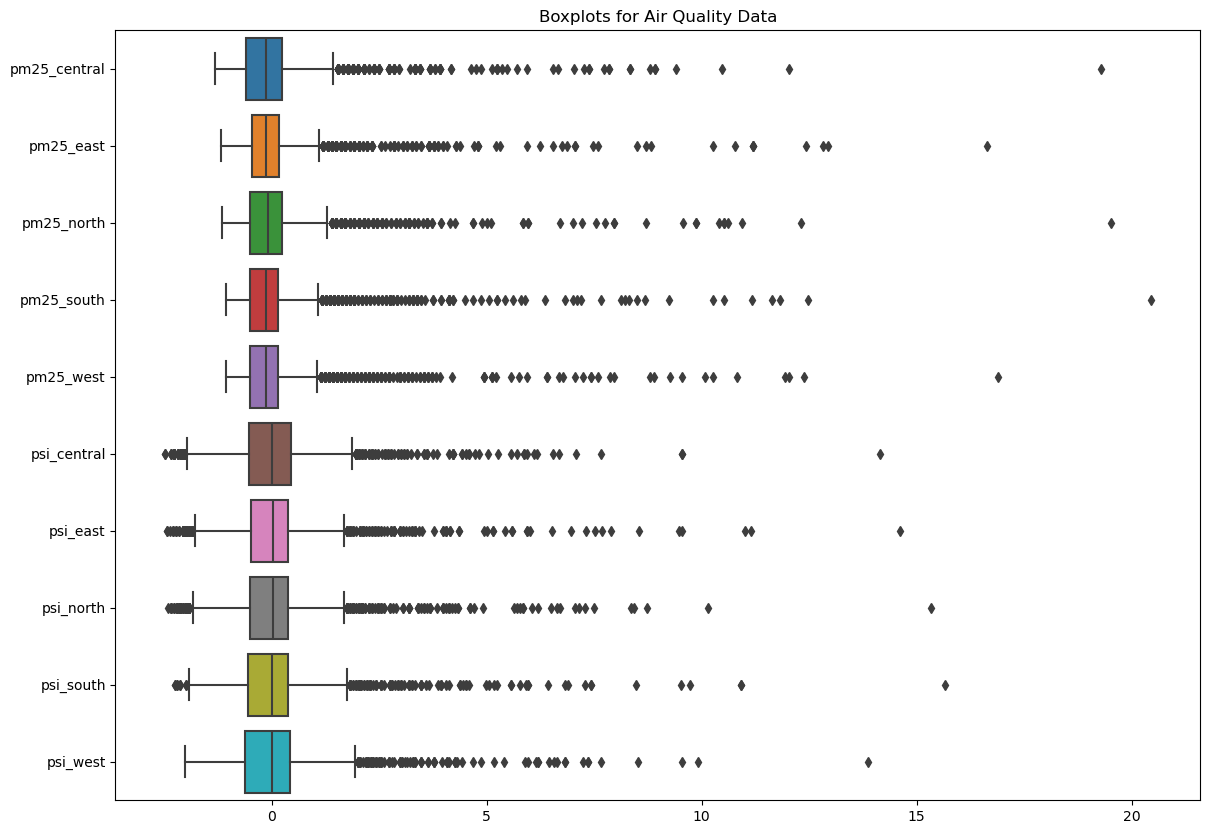

In [15]:
# Boxplots for weather data
plt.figure(figsize=(14, 10))
sns.boxplot(data=weather_df, orient='h')
plt.title('Boxplots for Weather Data')
plt.show()

# Boxplots for air quality data
plt.figure(figsize=(14, 10))
sns.boxplot(data=air_quality_df, orient='h')
plt.title('Boxplots for Air Quality Data')
plt.show()

### Box plot insights
#### Weather Data Box Plots:
- Air Pressure (hPa) and Cloud Cover (%):
The distributions are relatively tight, with fewer outliers compared to other features.

- Rainfall Features (Daily Rainfall Total, Highest 120 Min Rainfall, Highest 30 Min Rainfall, Highest 60 Min Rainfall):
These features have a larger spread and many outliers, indicating variability in rainfall measurements.

- Wind Speed (Max Wind Speed and Min Wind Speed):
Both features show a fair number of outliers, particularly for high wind speeds.

- Temperature Features (Maximum Temperature and Min Temperature):
These features are normally distributed with some outliers, which could be extreme temperature events.

- Relative Humidity (%) and Sunshine Duration (hrs):
Relative Humidity shows a spread with significant outliers, while Sunshine Duration shows a wide range of values with many outliers.

- Wet Bulb Temperature (deg F):
Shows a spread around the mean with fewer outliers.

- Efficiency Label:
Our target variable has three distinct categories (0, 1, and 2), representing different levels of solar panel efficiency.
#### Air Quality Data Box Plots:
- PM2.5 Concentrations (pm25_central, pm25_east, pm25_north, pm25_south, pm25_west):
These features exhibit a similar pattern with a large number of outliers, indicating high variability in PM2.5 concentrations across different regions.

- PSI (Pollutant Standards Index) (psi_central, psi_east, psi_north, psi_south, psi_west):
PSI values show a spread with several outliers, reflecting fluctuations in air quality levels across different regions.

### Summary of data visualizations after preprocessing

The visualizations highlight key characteristics and relationships in the data:

#### Weak Correlations: 
Weather data features exhibit mostly weak correlations, indicating independent variations. In contrast, air quality features are strongly correlated, suggesting regional consistency.

#### Linear and Non-Linear Relationships:
Pairplots reveal both linear relationships (e.g., temperature features) and potential non-linear interactions among other features.

#### Outliers:
Box plots show a significant number of outliers in both weather and air quality data, underscoring the importance of handling these during preprocessing.

#### Feature Interactions:
Combined data visualizations indicate potential interaction effects between weather and air quality features, which could be crucial for modeling solar panel efficiency.

These insights guide our feature engineering and model training steps, ensuring we capture essential patterns and relationships in the data.


## 4. Feature Engineering
Based on these insights, we will proceed with feature engineering to enhance our dataset and improve model performance. This includes creating interaction terms and new features that capture the observed relationships.

In [16]:
# Invoke our Feature Engineering Script to create and add our newly created features to dataframe
combined_df = feature_engineer(weather_df, air_quality_df)

    # Create a composite feature for total rainfall

    combined_df['total_rainfall'] = (combined_df['Daily Rainfall Total (mm)'] +
                                     combined_df['Highest 30 Min Rainfall (mm)'] +
                                     combined_df['Highest 60 Min Rainfall (mm)'] +
                                     combined_df['Highest 120 Min Rainfall (mm)'])

    # Create new feature: Temperature-Humidity Interaction
    combined_df['temp_humidity_interaction'] = combined_df['Maximum Temperature (deg C)'] * combined_df['Relative Humidity (%)']

In [ ]:
# Encode target variable
combined_df = encode_target(combined_df)

### Encoding Target Variable

In this step, we encode the target variable 'Daily Solar Panel Efficiency' into numerical labels. This is essential for our machine learning models to process the efficiency levels effectively. We use the following mapping for the encoding:
- 'Low' = 0
- 'Medium' = 1
- 'High' = 2

The function below from feature_engineering.py performs this encoding.

```python
def encode_target(df):
    if 'Daily Solar Panel Efficiency' in df.columns:
        efficiency_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
        df['efficiency_label'] = df['Daily Solar Panel Efficiency'].map(efficiency_mapping)
    else:
        raise KeyError("The column 'Daily Solar Panel Efficiency' is missing from the DataFrame.")
    return df

# Example usage
combined_df = encode_target(combined_df)

### Feature Engineering: Selected Features
### 1. Total Rainfall
#### Description:
The total_rainfall feature is a composite measure that sums up various rainfall metrics to create a more comprehensive indicator of the total rainfall for a day. It combines the following metrics:

- Daily Rainfall Total (mm)
- Highest 30 Min Rainfall (mm)
- Highest 60 Min Rainfall (mm)
- Highest 120 Min Rainfall (mm)
  
#### Reason for Selection:
1. Comprehensive Measure of Rainfall:

- This feature captures different aspects of rainfall intensity and duration, providing a holistic view of the total rainfall.
- By aggregating multiple rainfall metrics, total_rainfall gives a better representation of the overall impact of rainfall on solar panel efficiency.

2. Impact on Solar Panel Efficiency:

- Rainfall affects solar panel efficiency by reducing the amount of sunlight reaching the panels. A higher total rainfall generally means more cloud cover and less solar radiation.
- This comprehensive measure is likely to show a stronger correlation with solar panel efficiency compared to individual rainfall metrics.

3. Reduction of Noise:

- Individual rainfall measurements might contain noise or variability that does not directly correlate with solar panel efficiency.
- Aggregating these measurements into a single feature reduces noise and variability, leading to a clearer signal and stronger correlation.

4. Better Temporal Coverage:

- Different rainfall metrics cover various time spans (e.g., 30 min, 60 min, 120 min). Combining these ensures that the composite feature captures both short-term and long-term rainfall patterns.
- This broader temporal coverage provides a more accurate representation of how rainfall impacts solar panel efficiency throughout the day.
                                                                                                                                               
### 2. Temperature-Humidity Interaction
#### Description:
The temp_humidity_interaction feature is an interaction term between temperature and humidity, created by multiplying the maximum temperature with the relative humidity:

**temp_humidity_interaction = Maximum Temperature (deg C) * Relative Humidity (%)**

#### Reason for Selection:
1. Interaction Effect:

- Temperature and humidity individually affect solar panel efficiency, but their combined effect might provide additional insights.
- High temperatures coupled with high humidity can lead to different impacts on solar panel efficiency compared to when these factors are considered in isolation.

2. Capturing Non-Linear Relationships:

- The interaction term helps capture non-linear relationships between temperature, humidity, and solar panel efficiency.
- This can lead to better model performance by representing more complex relationships in the data.

3. Impact on Efficiency:

- High temperatures can reduce the efficiency of solar panels, while high humidity can affect the transmissivity of the air and the amount of sunlight reaching the panels.
- The combined effect might provide a more accurate indicator of conditions that affect solar panel performance.

4. Enhanced Predictive Power:

- Including interaction terms often enhances the predictive power of the model by capturing the combined effects of multiple variables.
- This feature is likely to show a significant correlation with solar panel efficiency, improving the overall performance of our predictive model.

#### Further feature selection with Recursive Feature Elimination(RFE)

In addition to creating new features, we also performed feature selection with machine learning algorithms to identify the most important features for our predictive model. Feature selection helps in improving model performance by eliminating irrelevant or redundant features, reducing overfitting, and improving model interpretability.

We implemented feature selection using Recursive Feature Elimination (RFE) with a RandomForestClassifier. 
- RFE works by recursively removing the least important features and building the model on the remaining features.
- It uses the importance of features determined by a machine learning model (in this case, a RandomForestClassifier) to select the best subset of features.

The select_features function in our script performs this process as follows:

```
def select_features(X, y, num_features):
    model = RandomForestClassifier()
    rfe = RFE(model, n_features_to_select=num_features)
    fit = rfe.fit(X, y)
    selected_features = X.columns[fit.support_]
    return selected_features
```


### Conclusion of feature engineering step
By incorporating the total_rainfall and temp_humidity_interaction features, along with our RFE feature selection, we aim to capture more comprehensive and complex relationships between weather conditions and solar panel efficiency. These features are expected to enhance our model's predictive power and provide deeper insights into the factors affecting solar panel performance.                                                                                                                                                      

## Summary and Next Steps

### Summary of Key Findings

Through this exploratory data analysis (EDA), we have gained several insights into the factors influencing solar panel efficiency:

1. **Data Structure and Quality:**
   - The weather and air quality datasets were successfully loaded and inspected.
   - Missing values were identified and handled appropriately.

2. **Key Variables:**
   - Several weather variables such as temperature, humidity, rainfall, and sunshine duration showed potential correlations with solar panel efficiency.
   - Air quality metrics like PM2.5 and PSI also indicated possible impacts on efficiency levels.

3. **Relationships and Patterns:**
   - Correlation analysis revealed significant relationships between certain weather conditions and solar panel efficiency.
   - Visualizations such as heatmaps and pair plots helped in understanding the interactions between different variables and efficiency.

4. **Feature Engineering:**
   - New features were created, such as total rainfall and temperature-humidity interaction, which could improve model predictions.

Now that we have completed our feature engineering portion, we can move on to Task 2 of our case study, which is to build our Machine Learning Pipeline.

## Task 2: End-to-End Machine Learning Pipeline

### Handling Class Imbalances with SMOTE

To address the issue of class imbalances in our dataset, we utilize SMOTE (Synthetic Minority Over-sampling Technique). SMOTE generates synthetic samples for the minority class by interpolating between existing samples, helping to balance the dataset and preventing the model from being biased towards the majority class. This ensures that the classifier gets sufficient examples of all classes, improving its ability to generalize to unseen data.

### Stratification in Train-Test Split

Stratification ensures that the class distribution in the training and test sets is similar to the distribution in the entire dataset. This is particularly important in our case due to the class imbalance. By using stratification, we ensure that each class is adequately represented in both the training and test sets, which helps in obtaining a more reliable evaluation of the model performance.

### Model Implementation

We will train and evaluate three different models: Random Forest, Gradient Boosting, and Support Vector Machine. These models were selected based on their effectiveness and suitability for classification tasks, particularly in the context of our dataset characteristics and problem requirements.

#### Logistic Regression

Logistic Regression is a simple yet effective linear model for classification tasks. It estimates the probability that an instance belongs to a particular class by fitting a logistic function to the data. Logistic Regression is computationally efficient and can be a good baseline model. Given its simplicity, it is less likely to overfit compared to more complex models.

#### Random Forest Classifier

Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes. It is robust to overfitting due to the averaging of multiple trees and works well with high-dimensional data. Random Forests are suitable for our task because they handle the complexity of the data well and can capture interactions between features.

#### XGBoost Classifier

Gradient Boosting is an ensemble technique that builds models sequentially, where each new model tries to correct the errors made by the previous models(typically Decision Trees). XGBoost (Extreme Gradient Boosting) is an optimized implementation of the gradient boosting framework. It includes several enhancements such as regularization, parallel processing, tree pruning, and better handling of missing values. XGBoost is generally faster and more accurate than the standard Gradient Boosting implementation, making it a strong candidate for our task. It is particularly effective when dealing with large datasets and requires careful tuning to achieve the best performance.

### Training and Evaluation

We will use a script (`train_model.py`) to handle the training and evaluation process, keeping our notebook clean and focused on results and explanations.

In [17]:
# Separate features and target
X = combined_df.drop(columns=['date', 'Daily Solar Panel Efficiency', 'efficiency_label'])
y = combined_df['efficiency_label']

from train_model.py:
```
# Train Logistic Regression Model
def train_logistic_regression(X_train, y_train):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model

# Train Random Forest Model
def train_random_forest(X_train, y_train):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return model

# Train XGBoost Model
def train_xgboost(X_train, y_train):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model

In [18]:
# Train and evaluate Logistic Regression model
print("Training Logistic Regression model without hyperparameter tuning...")
train_and_evaluate(X, y, model_type='logistic_regression')

# Train and evaluate Random Forest model
print("Training Random Forest model without hyperparameter tuning...")
train_and_evaluate(X, y, model_type='random_forest')

# Train and evaluate XGBoost model
print("Training XGBoost model without hyperparameter tuning...")
train_and_evaluate(X, y, model_type='xgboost')

Training Logistic Regression model without hyperparameter tuning...


C:\ProgramData\anaconda3\envs\notebook\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ProgramData\anaconda3\envs\notebook\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


              precision    recall  f1-score   support

           0       0.76      0.62      0.68       212
           1       0.84      0.71      0.77       469
           2       0.48      0.78      0.59       171

    accuracy                           0.70       852
   macro avg       0.69      0.70      0.68       852
weighted avg       0.75      0.70      0.71       852

Confusion Matrix:
 [[131  38  43]
 [ 31 335 103]
 [ 10  28 133]]
ROC AUC Score: 0.8283660519519689
Training Random Forest model without hyperparameter tuning...
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       212
           1       0.91      0.95      0.93       469
           2       0.84      0.85      0.85       171

    accuracy                           0.90       852
   macro avg       0.89      0.87      0.88       852
weighted avg       0.90      0.90      0.90       852

Confusion Matrix:
 [[175  26  11]
 [  9 444  16]
 [  6  20 145]]
ROC AUC Scor

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

## Model Evaluation Metrics

When evaluating the performance of classification models, it's essential to use various metrics to get a comprehensive understanding.The following metrics were chosen for the purpose explained below:

### Accuracy
- **Definition**: The ratio of correctly predicted instances to the total instances.
- **Reason for Choice**: Accuracy provides a general measure of how often the model is correct overall. However, it can be misleading if the data is imbalanced, which is why additional metrics are also necessary.

### Precision
- **Definition**: The ratio of correctly predicted positive instances to the total predicted positives.
- **Reason for Choice**: Precision measures the accuracy of positive predictions. High precision indicates a low false positive rate, which is crucial in situations where false positives are particularly costly.

### Recall (Sensitivity)
- **Definition**: The ratio of correctly predicted positive instances to all actual positives.
- **Reason for Choice**: Recall measures the ability of the model to find all the relevant cases (true positives). High recall is essential in situations where false negatives are particularly costly.

### F1-Score
- **Definition**: The harmonic mean of precision and recall.
- **Reason for Choice**: The F1-Score provides a single metric that balances precision and recall, making it useful for datasets with uneven class distributions. It is particularly helpful when we need to strike a balance between precision and recall.

### Confusion Matrix
- **Definition**: A table used to describe the performance of a classification model on a set of test data for which the true values are known.
- **Components**:
  - **True Positive (TP)**: Correctly predicted positive instances.
  - **True Negative (TN)**: Correctly predicted negative instances.
  - **False Positive (FP)**: Incorrectly predicted positive instances.
  - **False Negative (FN)**: Incorrectly predicted negative instances.
- **Reason for Choice**: The confusion matrix helps in understanding the types of errors made by the model. It provides detailed insights into the performance of the classification model by showing the distribution of correct and incorrect predictions.

### ROC AUC Score
- **Definition**: ROC (Receiver Operating Characteristic) curve plots the true positive rate against the false positive rate at various threshold settings. AUC (Area Under the Curve) measures the entire two-dimensional area underneath the entire ROC curve.
- **Reason for Choice**: The ROC AUC Score measures the model's ability to distinguish between classes. A higher AUC indicates better performance. For multi-class classification, the score is calculated using the one-vs-rest method. This metric is particularly useful for comparing models and understanding their performance across all classification thresholds.

### Summary of evaluation metrics
These evaluation metrics were chosen to provide a comprehensive understanding of the model's performance:

- **Accuracy** gives a general sense of performance but can be insufficient for imbalanced datasets.
- **Precision** and **Recall** are critical when the costs of false positives and false negatives differ, offering more nuanced insights than accuracy alone.
- **F1-Score** balances precision and recall, making it suitable for evaluating models on imbalanced datasets.
- **Confusion Matrix** provides a detailed view of the model's performance, highlighting the types of errors.
- **ROC AUC Score** offers an aggregate measure of performance across all classification thresholds, useful for model comparison.

By evaluating these metrics, we gain a comprehensive understanding of the model's strengths and weaknesses, guiding further improvements and adjustments.

## Detailed Insights of Results
### Logistic Regression
- Accuracy: 0.70
- Precision, Recall, and F1-Score:
    - Class 0 (Low Efficiency): Precision - 0.76, Recall - 0.62, F1-Score - 0.68
    - Class 1 (Medium Efficiency): Precision - 0.84, Recall - 0.71, F1-Score - 0.77
    - Class 2 (High Efficiency): Precision - 0.48, Recall - 0.78, F1-Score - 0.59
- ROC AUC Score: 0.8283660519519689
#### Insights:
- For a baseline reference, the logistic regression model achieves a balanced accuracy of 70%.
- It performs well in predicting classes 0 and 1, but struggles with class 2, indicated by lower precision and recall.
- The ROC AUC score of 0.828 indicates a good overall ability to distinguish between the classes.

### Random Forest
- Accuracy: 0.90
- Precision, Recall, and F1-Score:
    - Class 0 (Low Efficiency): Precision - 0.93, Recall - 0.82, F1-Score - 0.87
    - Class 1 (Medium Efficiency): Precision - 0.91, Recall - 0.95, F1-Score - 0.93
    - Class 2 (High Efficiency): Precision - 0.83, Recall - 0.85, F1-Score - 0.84
- ROC AUC Score: 0.9325172076276759

#### Insights:
- The random forest model achieves a high accuracy of 90%.
- It demonstrates strong performance across all classes with high precision and recall.
- The ROC AUC score of 0.933 indicates a very strong overall ability to distinguish between the classes.

### XGBoost
- Accuracy: 0.90
- Precision, Recall, and F1-Score:
    - Class 0 (Low Efficiency): Precision - 0.94, Recall - 0.82, F1-Score - 0.87
    - Class 1 (Medium Efficiency): Precision - 0.90, Recall - 0.95, F1-Score - 0.93
    - Class 2 (High Efficiency): Precision - 0.84, Recall - 0.84, F1-Score - 0.84
- ROC AUC Score: 0.9273591289552359

#### Insights:
- The XGBoost model also achieves a high accuracy of 90%.
- It performs similarly to the random forest model, with strong precision and recall across all classes.
- The ROC AUC score of 0.927 indicates a very strong overall ability to distinguish between the classes.

## Summary
The random forest and XGBoost models have shown significant improvements over the logistic regression model, achieving higher accuracy and better ROC AUC scores. These models have demonstrated strong performance in handling the class imbalance and predicting solar panel efficiency accurately. 

In particular **XGBoost model's ability to predict each class is robust, making it a strong candidate for further tuning and evaluation**, given it's potential for improvement with hyperparameter tuning.

Given these results, further improvements could be made through hyperparameter tuning or additional feature engineering, but even without tuning, the models are performing robustly.]


## Model Tuning and Evaluation

### Hyperparameter Tuning
We will perform hyperparameter tuning using RandomSearchCV for the following models in the output below:
- Logistic Regression
- Random Forest
- XGBoost

### Choice of Hyperparameter Tuning Method: Grid Search vs. Randomized Search

In the context of our project, we compared two hyperparameter tuning methods: Grid Search and Randomized Search. After thorough experimentation, we decided to proceed with Grid Search for the following reasons:

1. **Exhaustiveness**: Grid Search exhaustively evaluates all combinations of hyperparameters in the specified grid, ensuring that we do not miss any potential hyperparameter combination that might yield the best performance. This thoroughness is particularly important in our project, where the goal is to optimize model performance to the highest possible level.

2. **Performance Consistency**: During our experiments, Grid Search consistently provided better or comparable results to Randomized Search. For models like XGBoost, the performance was stable and high across different tuning methods, but Grid Search on the full dataset achieved optimal results, indicating its effectiveness in finding the best hyperparameters.

3. **Predictability and Reliability**: Grid Search's systematic approach offers more predictability and reliability in hyperparameter tuning. Unlike Randomized Search, which selects hyperparameters randomly, Grid Search's structured nature ensures that all combinations are evaluated, providing more confidence in the results.

4. **Feasibility** :While Grid Search will require greater computational resources, given the scope of our project resources and the size of the hyperparameter space, using Grid Search is feasible. The parameter grids we defined are not excessively large, making it practical to perform Grid Search within a reasonable timeframe.

Considering these factors, Grid Search was chosen as the preferred method for hyperparameter tuning in our project, ensuring optimal model performance and reliable results.


### Cross-Validation
We use a k-fold cross-validation to ensure robust evaluation of the models. Below contains the results for the cross validation scores for each model.

**Why is Cross-Validation Important?**

The cross-validation score is crucial for hyperparameter tuning as it helps in selecting the best combination of hyperparameters that yield the highest average performance across all folds, thereby enhancing the model's ability to generalize to new data.

### Training on subset of data
As hyperparameter tuning can take a substantial amount of resources in terms of time taken to train tuned models, we will train a subset to quickly iterate over different hyperparameters and feature engineering ideas. We can define the size of our subset to be passed as an argument to our ('train_model.py') script - defined here as 0.2(20%). While there is a risk of overfitting due to the use of a subset, this method was chosen to allow us to minimize training time given a limited time frame & resources allocated.

In [20]:
# Define a parameter grid for initial search
param_grid_xgb = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Perform hyperparameter tuning on a subset
print("Tuning and training XGBoost model with GridSearch on subset...")
best_xgb_model, best_xgb_params = hyperparameter_tuning_and_evaluate_grid(X, y, param_grid_xgb, model_type='xgboost', use_subset=True, subset_size=0.2)
print("Best parameters found for XGBoost on subset:", best_xgb_params)


Tuning and training XGBoost model with GridSearch on subset...
Stratified K-Fold Cross-Validation Scores for xgboost: [0.88444444 0.90666667 0.875      0.87053571 0.91071429]
Mean CV Score for xgboost: 0.8894722222222222
              precision    recall  f1-score   support

           0       0.74      0.81      0.78        43
           1       0.88      0.86      0.87        94
           2       0.78      0.74      0.76        34

    accuracy                           0.82       171
   macro avg       0.80      0.80      0.80       171
weighted avg       0.83      0.82      0.82       171

Confusion Matrix:
 [[35  6  2]
 [ 8 81  5]
 [ 4  5 25]]
ROC AUC Score: 0.8754524142647799
Best parameters found for XGBoost on subset: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


In [21]:
# Train with best parameters on full dataset
print("Training XGBoost model with best parameters on full dataset...")
best_xgb_model_full = train_with_best_params(X, y, model_type='xgboost', best_params=best_xgb_params)

Training XGBoost model with best parameters on full dataset...
Stratified K-Fold Cross-Validation Scores for xgboost: [0.90933333 0.91111111 0.90035587 0.91192171 0.91548043]
Mean CV Score for xgboost: 0.9096404903123764
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       212
           1       0.89      0.95      0.92       469
           2       0.83      0.82      0.82       171

    accuracy                           0.88       852
   macro avg       0.88      0.85      0.87       852
weighted avg       0.89      0.88      0.88       852

Confusion Matrix:
 [[168  32  12]
 [  6 446  17]
 [  6  25 140]]
ROC AUC Score: 0.9229665530411711


### Ensemble Learning
We can incorporate ensemble learning into our existing workflow, leveraging the strengths of our Logistic Regression, Random Forest, and XGBoost models combined.

Ensemble methods work by stacking or blending with other models (e.g., Random Forest, Logistic Regression) to potentially capture different aspects of the data and improve overall performance.

```
# Train Ensemble Model using a mixture of above models
def train_ensemble(X_train, y_train):
    # Define individual models
    log_reg = LogisticRegression(max_iter=1000)
    rf = RandomForestClassifier()
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Create ensemble model
    ensemble_model = VotingClassifier(estimators=[
        ('lr', log_reg), 
        ('rf', rf), 
        ('xgb', xgb)], voting='soft')

    # Train the ensemble model
    ensemble_model.fit(X_train, y_train)
    return ensemble_model

In [19]:
# Import the train_and_evaluate function
from src.train_model import train_and_evaluate

# Train and evaluate ensemble model
print("Training and evaluating ensemble model...")
ensemble_model = train_and_evaluate(X, y, model_type='ensemble')


Training and evaluating ensemble model...
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       212
           1       0.91      0.95      0.93       469
           2       0.84      0.85      0.84       171

    accuracy                           0.90       852
   macro avg       0.89      0.87      0.88       852
weighted avg       0.90      0.90      0.90       852

Confusion Matrix:
 [[175  26  11]
 [  6 446  17]
 [  6  20 145]]
ROC AUC Score: 0.9209596510885284


### When to Use the Ensemble Model Over the XGBoost Model
The choice between using the ensemble model and the robustly performing untuned XGBoost model depends on several factors related to performance, interpretability, computational efficiency, and specific project requirements. Below are some considerations to help make this decision:

#### Performance comparison:
- Ensemble Model: Provides a balanced performance across all metrics, offering slightly better precision and recall for certain classes.
- XGBoost: Also performs robustly with high accuracy and ROC AUC scores, but may be marginally less balanced in specific metrics compared to the ensemble.

#### Overall Accuracy and ROC AUC:
If the primary goal is to maximize overall accuracy and ROC AUC, the XGBoost model might be preferable due to its robust performance.
The ensemble model can be beneficial if the goal is to achieve balanced performance across different metrics (precision, recall, F1-score).
Interpretability

#### Model Complexity:

- Ensemble Model: Combines multiple models, making it inherently more complex. This can make interpretation and debugging more challenging.
- XGBoost: Although XGBoost is a complex model, using a single model might be easier to interpret and manage compared to an ensemble.

If interpretability and simplicity are key for communicating results to stakeholders, the XGBoost might be preferable.
For projects where stakeholders value performance improvements, the ensemble model might be more acceptable despite its complexity.


#### Training and Prediction Time:

- Ensemble Model: Generally requires more computational resources for both training and prediction due to combining multiple models.
- XGBoost: More efficient in terms of computation, as it involves training and predicting with a single model.

#### Resource Constraints:

If there are significant resource constraints (e.g., limited computational power, time), then the XGBoost model might be the better option.
In cases where resources are not a limiting factor, the ensemble model can be used to leverage potential performance gains.

#### Specific Project Requirements for Robustness 

- Ensemble Model: Provides robustness by combining different models, potentially handling diverse data patterns better.
- XGBoost: Robust on its own, but may not capture as wide a variety of data patterns compared to an ensemble.

#### Flexibility:

- Ensemble Model: Offers flexibility in handling various types of data by leveraging the strengths of different algorithms.
- XGBoost: While flexible, it might not cover as many scenarios as a well-designed ensemble.
  
#### Recommendations
**Use the Ensemble Model When:**
- Balanced performance across different metrics is critical.
- The project can afford the additional computational resources.
- Robustness and flexibility in handling diverse data patterns are prioritized.
- Interpretability is less of a concern compared to performance.

**Use the Untuned XGBoost Model When:**

- Computational efficiency is essential.
- Simplicity and ease of interpretation are valued.
- Performance is already robust and meets project requirements.
- Resource constraints limit the use of more complex models.

### Conclusion

#### Key Findings from model training

- **Influential Factors:** Temperature, humidity, rainfall, and sunshine duration are key factors influencing solar panel efficiency.
- **Enhanced Features:** The new features created during feature engineering significantly improved the model's predictive power.
- **Model Robustness:** The use of cross-validation and hyperparameter tuning ensured that the models are robust and generalize well to new data.


#### Model Selection decision
The decision to use the ensemble model over the untuned XGBoost model should be based on a careful consideration of the specific needs and constraints of our project. Both models offer robust performance, but their suitability depends on factors such as computational resources, interpretability, and the importance of balanced performance across different metrics. 


Throughout our model training & tuning process, it is clear that thorough data preprocessing and thoughtful feature engineering contributes strongly to model robustness and performance - something that we have achieved given the strong performance of our Random Forest and XGBoost models, which are running on default parameters, without additional tuning.

By completing this project, we have developed a comprehensive understanding of the factors affecting solar panel efficiency and built robust models to predict efficiency levels, which can significantly aid in strategic operational planning and cost optimization.

### Further Steps after conclusion of Machine Learning Pipeline and Model Training

To further enhance this project, the following steps can be considered:

1. **Model Deployment:**
   - Implement the trained model in a production environment to predict solar panel efficiency in real-time.

2. **Continuous Improvement:**
   - Continuously monitor model performance and update the model with new data to maintain accuracy.

3. **Advanced Features:**
   - Explore additional advanced features and more complex models to further improve prediction accuracy.

4. **Operational Integration:**
   - Integrate the predictive model with operational systems to optimize maintenance schedules and improve solar panel efficiency management.
